In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import math
# import struct
# from skimage import transform
import itertools, operator
from torch.optim.lr_scheduler import _LRScheduler

import glob
import pickle

import numpy as np
# from PIL import Image
import torch
from torch import nn
# import torch.nn.functional as F

# from torch.autograd import Variable

import cv2

from data_process import *
from model import *
# from regionLoss import *
from bbox import *
from draw import *
from v3loss import Yolov3Loss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
classes =  np.array(['sheep', 'horse', 'bicycle', 'bottle', 'cow', 'sofa', 'car', 'dog', 'cat', 'person', 'train', 'diningtable', 'aeroplane', 'bus', 'pottedplant', 'tvmonitor', 'chair', 'bird', 'boat', 'motorbike'])

In [3]:
def get_map(output, labels, n_true, iou_thresh):
    nms_boxes, nms_classes = get_nms_boxes(output, 0.5, 0.5, meta)
    mean_avg_prec = calc_map(labels, nms_boxes, nms_classes, n_true.numpy(), iou_thresh)
    return mean_avg_prec

def train(model, train_data, opt, iou_thresh, loss_fn):
    train_images = train_data["image"].cuda().float()
    train_labels = train_data["bboxes"].cuda().float()
    train_n_true = train_data["n_true"]
    opt.zero_grad()
    train_output = model(train_images)
    loss = loss_fn(train_output, train_labels, train_n_true)
    loss.backward()
    opt.step()
    train_map = get_map(train_output, train_labels, train_n_true, iou_thresh)
    return loss, train_map

In [4]:
def validate(model, test_data, iou_thresh, loss_fn):
    test_images = test_data["image"].cuda().float()
    test_labels = test_data["bboxes"].cuda().float()
    test_n_true = test_data["n_true"]

    test_output = model(test_images)
    test_loss = loss_fn(test_output, test_labels, test_n_true)
    test_map = get_map(test_output, test_labels, test_n_true, iou_thresh)
    return test_loss, test_map
        

Set all meta parameters.

In [5]:
batch_size = 8
meta = defaultdict()
meta['anchors'] = 5
meta['classes'] = 20
meta['batch_size'] = batch_size
meta['threshold'] = 0.6
meta['anchor_bias'] = np.array([1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52])
meta['scale_no_obj'] = 1
meta['scale_coords'] = 1
meta['scale_class'] = 1
meta['scale_obj']  = 5
meta['iteration'] = 0 

Increase Learning rate to see what learning rate would be most effective.

iteration 0 loss 3.8318822383880615 map 0.0
iteration 20 loss 2.817347526550293 map 0.0
iteration 40 loss 2.347586154937744 map 0.0
iteration 60 loss 3.439117908477783 map 0.0
iteration 80 loss 2.7455742359161377 map 0.0
iteration 100 loss 2.3640036582946777 map 0.0
iteration 120 loss 2.4262681007385254 map 0.0
iteration 140 loss 2.4859423637390137 map 0.0
iteration 160 loss 2.4979615211486816 map 0.0
iteration 180 loss 3.050687074661255 map 0.0
iteration 200 loss 3.418060302734375 map 0.0
iteration 220 loss 2.5984978675842285 map 0.0
iteration 240 loss 3.2048797607421875 map 0.0
iteration 260 loss 2.977407217025757 map 0.0
iteration 280 loss 2.5987389087677 map 0.0
iteration 300 loss 2.750260353088379 map 0.0
iteration 320 loss 2.7596752643585205 map 0.0
iteration 340 loss 2.7671029567718506 map 0.0
iteration 360 loss 2.7923812866210938 map 0.0
iteration 380 loss 2.2260990142822266 map 0.0
iteration 400 loss 2.6814892292022705 map 0.0
iteration 420 loss 2.3907995223999023 map 0.0
iter

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8f95224f98>>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/root/miniconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/root/miniconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/root/miniconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/root/miniconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(add

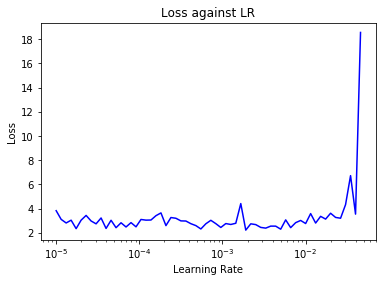

CPU times: user 41.5 s, sys: 26.1 s, total: 1min 7s
Wall time: 1min 7s


In [6]:
%%time
batch_size = 10
mini_train_loader, len_train = get_data('./data/train1000.pickle', 
                                        shuffle=True, 
                                        batch_size=batch_size,
                                        num_workers=4)
meta['iterations_per_epoch'] = len(mini_train_loader)

# get the loss and model functions
model = Yolov2().cuda()
output_mapping_shape = (13, 13)
loss = Yolov3Loss()
loss.set_params(output_mapping_shape, meta)

# set up a learning rate scheduler
start_lr = 0.00001
end_lr = 10
optim = torch.optim.Adam(model.parameters(), start_lr)
lr_decay = (end_lr/start_lr)** (1./meta['iterations_per_epoch'])
sched = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)

losses = []
lrs = []
best_loss = 10**10
meta['iteration'] = 0

for i, train_data in enumerate(mini_train_loader):
    sched.step()

    loss_val, acc_map = train(model, train_data, optim, 0.3, loss.loss)

    lrs.append(sched.get_lr()[0])
    losses.append(loss_val)
    if loss_val < best_loss:
        best_loss = loss_val

    if loss_val > 4*best_loss:
        break

    if meta['iteration']%20 == 0:
        print ("iteration {0} loss {1} map {2}".format(meta['iteration'], loss_val, acc_map[0]))
    meta['iteration'] += batch_size
    
plt.plot(lrs, losses, 'b-')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss against LR')
plt.show()

Train the model now with chosen learning rate:

In [ ]:
# # get the loss and model functions
# model = Yolov2().cuda()
# output_mapping_shape = (13, 13)
# loss = Yolov3Loss()
# loss.set_params(output_mapping_shape, meta)

# # optimiser and (step) scheduler
# optim = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.9)

# # data generator
# train_loader, len_train = get_data('./data/train.pickle', 
#                                         shuffle=True, 
#                                         batch_size=batch_size,
#                                         num_workers=4)
# meta['iterations_per_epoch'] = len(train_loader)

epochs = 100
# losses = []
# maps = []
for epoch in range(1, epochs):
    scheduler.step()
    for i, train_data in enumerate(train_loader):
        loss_val, acc_map = train(model, train_data, optim, 0.3, loss.loss)
        losses.append(loss_val)
        maps.append(acc_map)
    if epoch == 1:
        loss.set_early_loss(False)

    print ("iteration {0} loss {1} map {2}".format(epoch, loss_val, acc_map[0]))
    with open('train_log','a+') as f:
        f.write("iteration {0} loss {1} map {2}\n".format(epoch, loss_val, acc_map[0]))
        
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), 'checkpoint_{0}.pth'.format(epoch))

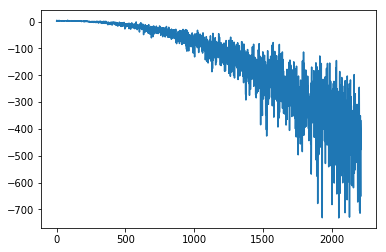

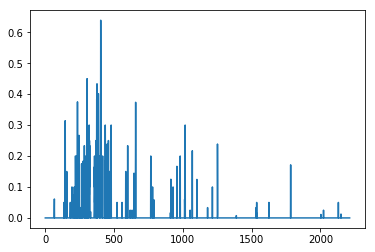

In [16]:
plt.plot(losses)
plt.show()
plt.plot(maps)
plt.show()

In [28]:
len(train_loader)

100

In [29]:
train_loader.batch_size

10

In [27]:
loss2 = lambda x: loss.loss(*x, early_loss=False)

TypeError: loss() missing 3 required positional arguments: 'output', 'labels', and 'n_truths'

In [19]:
meta

defaultdict(None,
            {'anchors': 5,
             'classes': 20,
             'batch_size': 10,
             'threshold': 0.6,
             'anchor_bias': array([ 1.08,  1.19,  3.42,  4.41,  6.63, 11.38,  9.42,  5.11, 16.62,
                    10.52]),
             'scale_no_obj': 1,
             'scale_coords': 1,
             'scale_class': 1,
             'scale_obj': 5,
             'iteration': 730,
             'iterations_per_epoch': 100})

In [ ]:
class CosineAnnealingLR(_LRScheduler):

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]


In [ ]:
def train_last_layers(model, lr_est, n_cycles=1, epochs_per_cycle=1, cycle_mult=1):
#     sample_size = 1920
    train_loader, test_loader = get_data(batch_size=batch_size)

    metrics = {'train':{'loss':[], 'acc': []}, 'test': {'loss': [], 'acc': []}}
    # No Layer Groups
    opt = get_optimizer(model, [lr_est])
    
    meta['iteration'] = 0
    for cycle in range(n_cycles):
                
        # resetting the lr to original
        param_groups = opt.param_groups
        for param_group in param_groups:
            param_group['lr'] = lr_est

        cycle_len = meta['iterations_per_epoch'] * epochs_per_cycle
        sched = CosineAnnealingLR(opt, cycle_len)

        for epoch in range(epochs_per_cycle):
            
            for i, train_data in enumerate(train_loader):
                if train_data["image"].size(0) != batch_size:
                    break
                
                sched.step()
                loss, acc_map = train(model, train_data, opt, 0.3)
                loss_val = loss.data[0]
                acc_val = acc_map.data[0]
                metrics['train']['loss'].append(loss_val)
                metrics['train']['acc'].append(acc_val)
                
                meta['iteration'] += batch_size
                
                if meta['iteration']%(4*batch_size) == 0:
                    total_test_loss = []
                    total_test_acc = []
                    for i, test_data in enumerate(test_loader):
                        if test_data["image"].size(0) != batch_size:
                            break
                        
                        test_loss, test_acc = validate(model, test_data, 0.3)
                        total_test_loss.append(test_loss.data[0])
                        total_test_acc.append(test_acc.data[0])
                    
                    test_loss = np.mean(total_test_loss)
                    test_acc = np.mean(total_test_acc)
                    
                    metrics['test']['loss'].append(test_loss)
                    metrics['test']['acc'].append(test_acc)
                    print ("Iteration {0} Train Loss {1} Acc {2} Test Loss {3} Acc {4}".format(
                        meta['iteration'], loss_val, acc_val, test_loss, test_acc))
                    
                        
        epochs_per_cycle *= cycle_mult
    
    return model, metrics


In [ ]:
model = get_model()

In [ ]:
metrics = train_last_layers(model, start_lr)

In [ ]:
model.cpu()

In [ ]:
torch.save(model, open("model_2", "wb"))

In [ ]:
model = torch.load(open("model", "rb"))

In [ ]:
train_loader, test_loader = get_data(batch_size=batch_size)
for i, test_data in enumerate(test_loader):
    test_images = Variable(test_data["image"], requires_grad=False).cuda().float()
    test_labels = Variable(test_data["bboxes"], requires_grad=False).cuda().float()
    test_n_true = test_data["n_true"]
    break

In [ ]:
test_output = model(test_images)

In [ ]:
test_output

In [ ]:
nnms = get_nms_boxes(test_output, 0.24, 0.3)

In [ ]:
draw_bbox_torch({"image": test_images[0].cpu().data, "bboxes": test_labels[0].cpu().data})

In [ ]:
draw_bbox_nms(test_images[0].cpu(), nnms[0].cpu())

In [ ]:
torch.max(nnms[0][0][5:], 0)

In [ ]:
classes[7]

In [ ]:
list(model.children())

In [ ]:
list(model.children())[4].weight.data

In [ ]:
model2 = get_model()

In [ ]:
list(model2.children())[4].weight.data

In [ ]:
list(model.children())[0].weight.data

In [ ]:
def train_all_layers(model, lrs, layer_groups, n_cycles=1, epochs_per_cycle=1, cycle_mult=1):
    
    train_loader, test_loader = get_data()
    opt = get_optimizer(model, [lr_est/100, lr_est/10, lr_est], [16, 36, 43])
    metrics = {'train':{'loss':[], 'acc': []}, 'test': {'loss': [], 'acc': []}}
    # No Layer Groups
    opt = get_optimizer(model, [lr_est])
    
    meta['iteration'] = 0
    for cycle in range(n_cycles):
                
        # resetting the lr to original
        param_groups = opt.param_groups
        for param_group in param_groups:
            param_group['lr'] = lr_est

        cycle_len = meta['iterations_per_epoch'] * epochs_per_cycle
        sched = CosineAnnealingLR(opt, cycle_len)

        for epoch in range(epochs_per_cycle):
            
            for i, train_data in enumerate(train_loader):
                if train_data["image"].size(0) != batch_size:
                    break
                
                sched.step()
                loss, acc_map = train(model, train_data, opt)
                loss_val = loss.data[0]
                acc_val = acc_map.data[0]
                metrics['train']['loss'].append(loss_val)
                metrics['train']['acc'].append(acc_val)
                
                meta['iteration'] += batch_size
                
                if meta['iteration']%100 == 0:
                    total_test_loss = []
                    total_test_acc = []
                    for i, test_data in enumerate(test_loader):
                        if test_data["image"].size(0) != batch_size:
                            break
                        
                        test_loss, test_acc = validate(model, test_data)
                        total_test_loss.append(test_loss.data[0])
                        total_test_acc.append(test_acc.data[0])
                    
                    test_loss = np.mean(total_test_loss)
                    test_acc = np.mean(total_test_acc)
                    
                    metrics['test']['loss'].append(test_loss)
                    metrics['test']['acc'].append(test_acc)
                    print ("Iteration {0} Train Loss {1} Acc {2} Test Loss {3} Acc {4}".format(
                        meta['iteration'], loss_val, acc_val, test_loss, test_acc))
                    
                        
        epochs_per_cycle *= cycle_mult
    
    return model, metrics

    

In [ ]:
epochs = 10

for epoch in range(epochs):
#     import pdb; pdb.set_trace()
    for i, train_data in enumerate(train_loader):
        if train_data["image"].size(0) != batch_size:
            continue
        train_images = Variable(train_data["image"], requires_grad=False).cuda().float()
        train_labels = Variable(train_data["bboxes"], requires_grad=False).cuda().float()
        train_n_true = train_data["n_true"]
        
        sched.step()
        optimizer.zero_grad()
        
        current_lr = optimizer.param_groups[0]['lr']
        updated_lr = current_lr * 1.0223509385032303
        print ("current lr -- updated lr", current_lr, updated_lr)
        optimizer.param_groups[0]['lr'] = updated_lr
        train_output = model(train_images)
        
        try:
            loss = Yolov2Loss(train_output, train_labels, train_n_true, meta)
        except Exception as e:
            print (iteration, i)
            raise e
        loss.backward()
        optimizer.step()
        lr_vals.append(updated_lr)
        loss_vals.append(loss.data[0])
        
        iteration += batch_size
        
        if iteration%2 == 0:
            
            test_total = 0
            test_total_map = torch.cuda.FloatTensor([0])
            for j, test_data in enumerate(test_loader):
                test_images = Variable(test_data["image"]).cuda().float()
                test_labels = Variable(test_data["bboxes"]).cuda().float()
                test_n_true = test_data["n_true"]
                
                test_output = model(test_images)
                test_nms = get_nms_detections(test_output, 0.4, 0.4)
                
                test_map = calc_map(test_labels, test_nms, test_n_true.numpy())
                test_total_map += test_map.data
                test_total += 1
            test_avg_map = test_total_map / test_total
            
            print ("Iteration {} loss {} accuracy {}".format(iteration, loss.data[0], test_avg_map))

In [ ]:
for i, b in enumerate(train_loader):
    img = b['image']
    bboxes = b['bboxes']
    break

draw_bbox_torch({"image": img[0], "bboxes":bboxes[0]})

out = model(Variable(img.float().cuda()))

iteration = 1
loss = Yolov2Loss(out, Variable(bboxes).cuda().float(), b['n_true'].numpy())

t = get_nms_detections(out)

mean_ap = calc_map(Variable(bboxes).float().cuda(), t, b['n_true'].numpy())